In [1]:
# !pip3 install matplotlib pandas seaborn numpy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [2]:
associations_df = pd.read_csv("data/space_time/associations_df.csv")
lp_schedule = pd.read_csv("schedules/time/milp_green.csv")
# lp_schedule = lp_schedule.drop(columns=['idx'])
greedy_green_schedule = pd.read_csv("schedules/time/green_case.csv")
greedy_green_schedule = greedy_green_schedule.drop(columns=['idx'])
worst_case_greedy_schedule = pd.read_csv("schedules/time/worst_case.csv")
worst_case_greedy_schedule = worst_case_greedy_schedule.drop(columns=['idx'])
basic_schedule = pd.read_csv("schedules/time/basic_planner.csv")
random_schedule = pd.read_csv("schedules/time/random_schedule.csv")
print(associations_df.columns)
print(associations_df['forecast_id'].unique())

Index(['node', 'job_id', 'forecast_id', 'transfer_time', 'throughput',
       'host_joules', 'link_joules', 'total_joules', 'avg_ci',
       'carbon_emissions'],
      dtype='object')
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


In [3]:
def visualize_job_carbon_intensity(associations_df, job_id):
    # Filter for the specified job
    job_df = associations_df[associations_df['job_id'] == job_id]

    # Pivot the data for heatmap format
    heatmap_data = job_df.pivot(index='node', columns='forecast_id', values='carbon_emissions')

    # Define color map
    cmap = mcolors.LinearSegmentedColormap.from_list("carbon_intensity_cmap", ["green", "yellow", "red"])
    norm = mcolors.Normalize(vmin=job_df['carbon_emissions'].min(), vmax=job_df['carbon_emissions'].max())

    # Plot with automatic contrasting text colors
    plt.figure(figsize=(15, 6))
    sns.heatmap(
        heatmap_data,
        cmap=cmap,
        norm=norm,
        annot=True,
        fmt=".1f",
        annot_kws={'color': 'black', 'weight': 'bold'},  # Set font properties
        cbar_kws={'label': 'Carbon Emissions (gCO2eq)'},
        linewidths=0.5,
        linecolor='black'
    )

    plt.xlabel('Forecast ID (Time Slot)', fontweight='bold')
    plt.ylabel('Node', fontweight='bold')
    plt.title(f'Carbon Emissions Heatmap for Job {job_id}', fontweight='bold', pad=20)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

In [4]:
def visualize_schedule(schedule_df, associations_df, name):
    # Get unique nodes and time slots (forecast_id) from associations_df
    nodes = associations_df['node'].unique()
    time_slots = sorted(associations_df['forecast_id'].unique())  # Use all unique time slots from associations_df

    # Create a grid of all nodes and time slots
    grid_df = pd.DataFrame([(node, t) for node in nodes for t in time_slots], columns=['node', 'forecast_id'])

    # Merge with schedule_df to get job assignments
    grid_df = grid_df.merge(
        schedule_df[['node', 'forecast_id', 'job_id', 'carbon_emissions']],
        on=['node', 'forecast_id'],
        how='left'
    )

    # Fill NaN job_id with -1 (no job scheduled) and NaN carbon_emissions with 0
    grid_df['job_id'] = grid_df['job_id'].fillna(-1)
    grid_df['carbon_emissions'] = grid_df['carbon_emissions'].fillna(0)

    # Aggregate data for each node and forecast_id
    aggregated_df = grid_df.groupby(['node', 'forecast_id'], as_index=False).agg({
        'job_id': lambda x: ', '.join(map(str, x[x != -1])) if any(x != -1) else '-1',  # Combine job IDs
        'carbon_emissions': 'sum'  # Sum carbon emissions
    })

    # Pivot the grid to create a heatmap-friendly format
    heatmap_data = aggregated_df.pivot(index='node', columns='forecast_id', values='carbon_emissions')
    job_data = aggregated_df.pivot(index='node', columns='forecast_id', values='job_id')

    # Define a color map for carbon emissions (green to red)
    cmap = mcolors.LinearSegmentedColormap.from_list("emissions_cmap", ["green", "red", "brown"])
    norm = mcolors.Normalize(vmin=associations_df['carbon_emissions'].min(),
                             vmax=associations_df['carbon_emissions'].max())

    # Plot the heatmap
    plt.figure(figsize=(15, 6))
    sns.heatmap(
        heatmap_data,
        cmap=cmap,  # Color map for carbon emissions
        norm=norm,  # Normalize emissions values
        annot=job_data,  # Show job IDs in cells
        fmt="",  # No special formatting for annotations
        cbar_kws={'label': 'Carbon Emissions'},
        linewidths=0.5,
        linecolor='black',
        mask=(job_data == '-1')  # Mask empty slots
    )

    # Customize the plot
    plt.xlabel('Forecast ID (Time Slot)')
    plt.ylabel('Node')
    plt.title(f'Job Schedule Heatmap - Colored by Carbon Emissions using {name}')
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

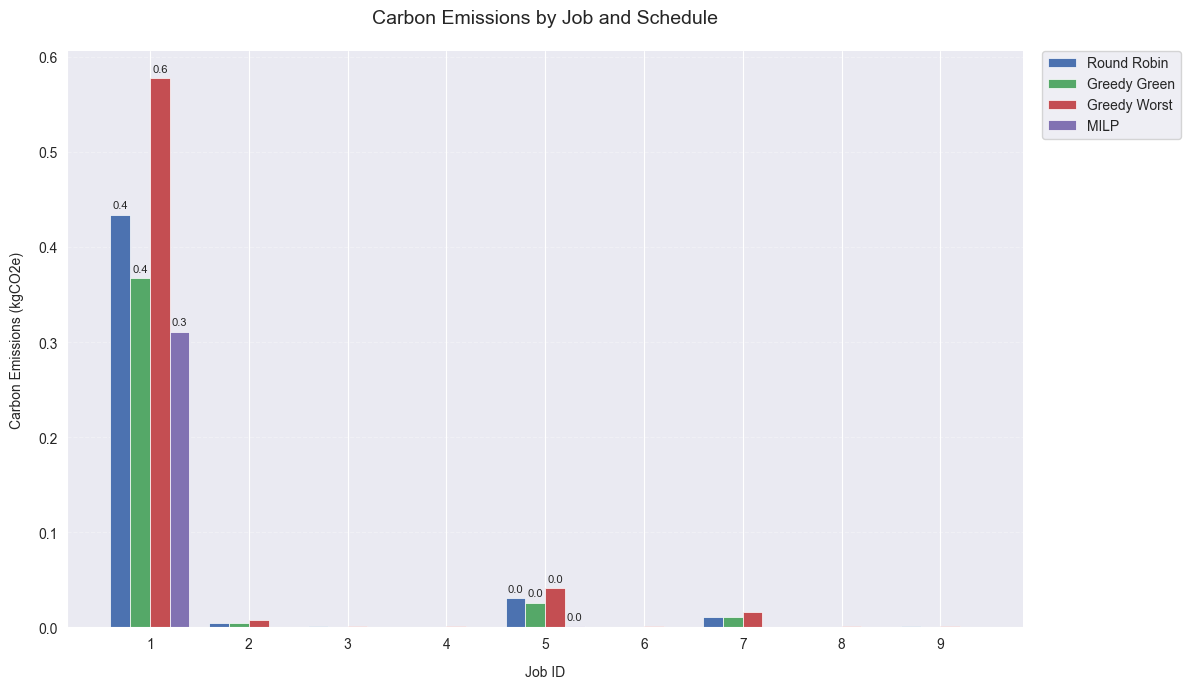

In [83]:
def plot_grouped_bars_kg(schedules, schedule_names):
    # Prepare data: sum emissions by job for each schedule and convert to kg
    data = []
    for schedule, name in zip(schedules, schedule_names):
        emissions = schedule.groupby('job_id')['carbon_emissions'].sum().reset_index()
        emissions['carbon_emissions_kg'] = emissions['carbon_emissions'] / 1000  # Convert g to kg
        emissions['schedule'] = name
        data.append(emissions)

    combined = pd.concat(data)

    # Pivot for plotting
    pivot_df = combined.pivot(index='job_id', columns='schedule', values='carbon_emissions_kg')

    # Plot setup
    fig, ax = plt.subplots(figsize=(12, 7))

    # Custom colors
    colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2']

    # Bar positions
    jobs = pivot_df.index
    x = np.arange(len(jobs))  # job locations
    width = 0.8 / len(schedule_names)  # width of bars

    # Create bars for each schedule
    for i, schedule in enumerate(schedule_names):
        offset = width * i
        rects = ax.bar(
            x + offset,
            pivot_df[schedule],
            width,
            label=schedule,
            color=colors[i],
            edgecolor='white',
            linewidth=0.5
        )

        # Add value labels for top 25% of bars
        for rect in rects:
            height = rect.get_height()
            if height > np.percentile(pivot_df[schedule].dropna(), 75):
                ax.annotate(f'{height:.1f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center',
                            va='bottom',
                            fontsize=8)

    # Customize plot
    ax.set_title('Carbon Emissions by Job and Schedule', pad=20, fontsize=14)
    ax.set_xlabel('Job ID', labelpad=10)
    ax.set_ylabel('Carbon Emissions (kgCO2e)', labelpad=10)
    ax.set_xticks(x + width*(len(schedule_names)-1)/2, jobs)

    # Improve legend
    ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

    # Grid and spines
    ax.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Use log scale only if needed (commented out by default)
    # if pivot_df.max().max() / pivot_df.min().min() > 100:  # Only if range > 100x
    #     ax.set_yscale('log')
    #     ax.set_ylabel('Carbon Emissions (kgCO₂e, log scale)')

    plt.tight_layout()
    plt.show()

# Example usage
schedules = [basic_schedule, greedy_green_schedule, worst_case_greedy_schedule, lp_schedule]
schedule_names = ["Round Robin", "Greedy Green", "Greedy Worst", "MILP"]
plot_grouped_bars_kg(schedules, schedule_names)

MILP Programming created a total emissions of 313.02323800988705
Greedy Carbon Min created a total emissions of 412.7568595833333
Greedy Carbon Max created a total emissions of 650.3818244658119
Round Robin created a total emissions of 484.07910294604704
Random created a total emissions of 499.03288424501415


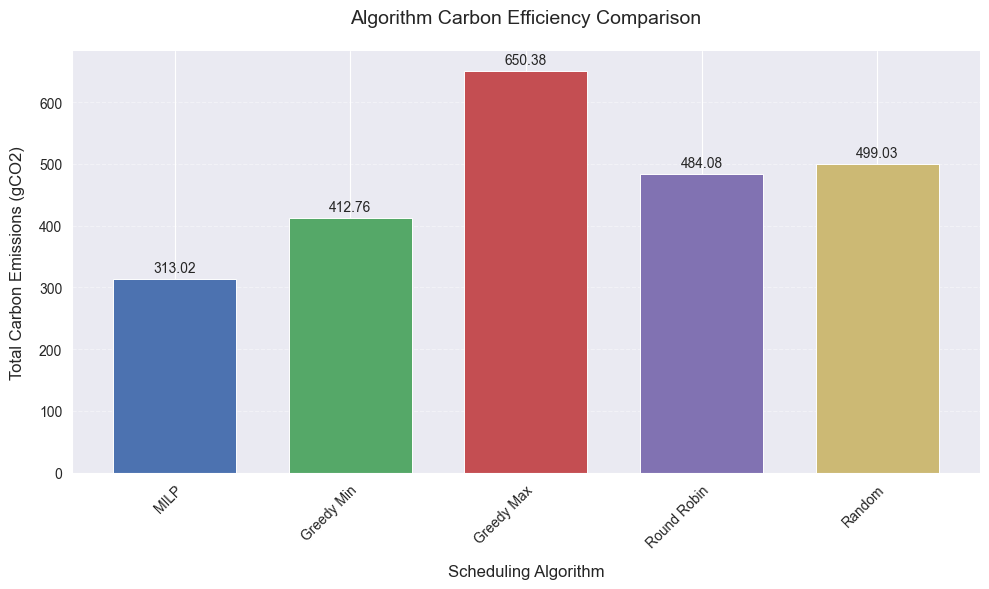

In [89]:
def total_emissions_schedule(schedule_df, schedule_name):
    total = schedule_df['carbon_emissions'].sum()
    print(f"{schedule_name} created a total emissions of {schedule_df['carbon_emissions'].sum()}")
    return total

def plot_algorithm_emissions_comparison():
    # Calculate totals (using your existing function)
    totals = [
        total_emissions_schedule(lp_schedule, "MILP Programming"),
        total_emissions_schedule(greedy_green_schedule, "Greedy Carbon Min"),
        total_emissions_schedule(worst_case_greedy_schedule, "Greedy Carbon Max"),
        total_emissions_schedule(basic_schedule, "Round Robin"),
        total_emissions_schedule(random_schedule, "Random")
    ]

    # Algorithm names (shortened for better fit)
    algorithms = ["MILP", "Greedy Min", "Greedy Max", "Round Robin", "Random"]

    # Create figure with adjusted size
    plt.figure(figsize=(10, 6))

    # Create bars with better colors
    colors = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974']
    bars = plt.bar(algorithms, totals, color=colors, width=0.7, edgecolor='white', linewidth=0.7)

    # Customize axes
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor', fontsize=10)
    plt.yticks(fontsize=10)

    # Add labels and title
    plt.xlabel("Scheduling Algorithm", fontsize=12, labelpad=10)
    plt.ylabel("Total Carbon Emissions (gCO2)", fontsize=12, labelpad=10)
    plt.title("Algorithm Carbon Efficiency Comparison", fontsize=14, pad=20)

    # Add value labels with improved positioning
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + (0.01*max(totals)),
                f'{height:,.2f}',
                ha='center', va='bottom',
                fontsize=10)

    # Add grid and clean borders
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

    # Adjust layout to prevent clipping
    plt.tight_layout()
    plt.savefig('graphs/bar_algo_comp.pdf', dpi=800)
    plt.show()

# Run the improved plot
plot_algorithm_emissions_comparison()

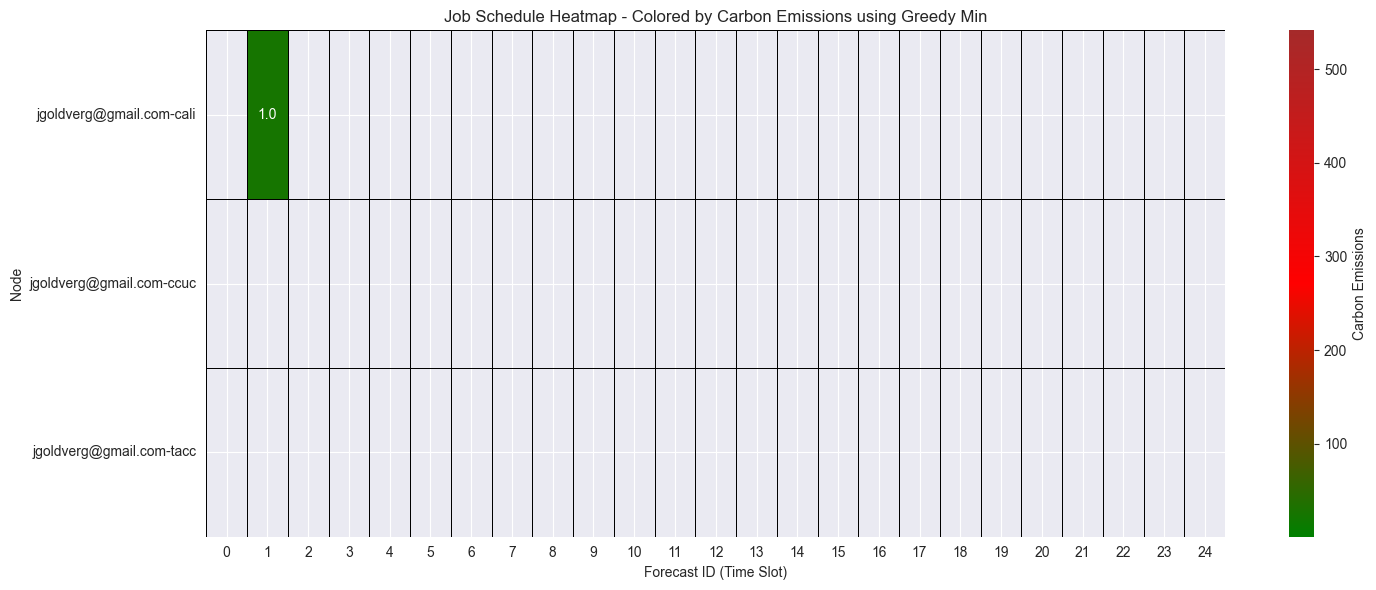

In [5]:
visualize_schedule(greedy_green_schedule, associations_df, "Greedy Min")

In [ ]:
import pandas as pd

forecasts_df = pd.read_csv('data/forecast_data.csv')
